In [158]:
import numpy as np
from sklearn.metrics import pairwise_distances

def make_binary_data(length=10, subset_size = 5, n_prototypes=5):
    strings = [list(np.binary_repr(x, width=length)) for x in np.arange(2**length)]
    bits = np.array(strings).astype(int)
    np.random.shuffle(bits)
    features = np.random.permutation(length)[:subset_size]
    dist = pairwise_distances(bits[:, features], bits[:n_prototypes][:, features]).min(axis=1)
    labels = (dist >= np.median(dist)).ravel()
    if len(np.unique(labels)) == 1:
        labels = dist == 0
    return bits, labels

In [72]:
dist.shape

(1024,)

In [73]:
(dist == np.median(dist)).sum()

432

In [74]:
np.median(dist)

1.4142135623730951

In [75]:
import pandas as pd
pd.Series(labels).value_counts()

True     560
False    464
dtype: int64

In [76]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [77]:
cross_validate(RandomForestClassifier(), bits, labels, cv=StratifiedKFold(shuffle=True))

{'fit_time': array([0.09593844, 0.09435225, 0.09722567, 0.0939095 , 0.09468651]),
 'score_time': array([0.00758719, 0.00879049, 0.00835013, 0.00797939, 0.00801229]),
 'test_score': array([1.        , 1.        , 1.        , 1.        , 0.98039216])}

In [78]:
cross_validate(MLPClassifier(), bits, labels, cv=StratifiedKFold(shuffle=True))

/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/li

{'fit_time': array([1.20306253, 1.33691144, 1.25735092, 1.35169673, 2.3661077 ]),
 'score_time': array([0.00070906, 0.00104403, 0.00080848, 0.00059152, 0.00056839]),
 'test_score': array([0.96585366, 1.        , 0.97560976, 0.99512195, 1.        ])}

In [79]:
from scripts.transformer_prediction_interface import TabPFNClassifier
tabpfn = TabPFNClassifier(device="cpu", model_string="tabpfn__emsize_512_nlayers_12_steps_2048_bs_32ada_lr_0.0001_1_gpu_07_24_2023_01_43_33", epoch="1650", N_ensemble_configurations=3)

In [80]:
cross_validate(tabpfn, bits, labels, cv=StratifiedKFold(shuffle=True))

{'fit_time': array([0.00045824, 0.00048542, 0.00049162, 0.00048018, 0.00042939]),
 'score_time': array([0.45148468, 1.54571772, 0.63233352, 0.48766923, 0.47936153]),
 'test_score': array([0.83902439, 0.8097561 , 0.87317073, 0.87804878, 0.86764706])}

In [88]:
rf_scores = []
tabpfn_scores = []
mlp_scores = []
import torch
torch.set_num_threads(1)
prototypes = np.arange(1, 10)
for n_prototypes in prototypes:
    for i in range(5):
        X, y = make_binary_data(length=10, subset_size=5, n_prototypes=n_prototypes)
        tabpfn_scores.append(np.mean(cross_validate(tabpfn, X, y)['test_score']))
        mlp_scores.append(np.mean(cross_validate(MLPClassifier(max_iter=1000), X, y)['test_score']))
        rf_scores.append(np.mean(cross_validate(RandomForestClassifier(), X, y)['test_score']))

In [97]:
df_subset_5_lenght_10 = pd.DataFrame({'tabpfn': tabpfn_scores, 'rf': rf_scores, 'mlp': mlp_scores, 'prototypes': np.repeat(prototypes, 5)})

In [98]:
df_subset_5_lenght_10

,tabpfn,rf,mlp,prototypes
0,1.000000,1.000000,1.0,1
1,1.000000,1.000000,1.0,1
2,1.000000,1.000000,1.0,1
3,1.000000,1.000000,1.0,1
4,1.000000,1.000000,1.0,1
5,0.874978,0.998049,1.0,2
6,1.000000,1.000000,1.0,2
7,0.857398,0.999024,1.0,2
8,0.800751,0.997073,1.0,2
9,1.000000,1.000000,1.0,2


<AxesSubplot:xlabel='prototypes', ylabel='value'>

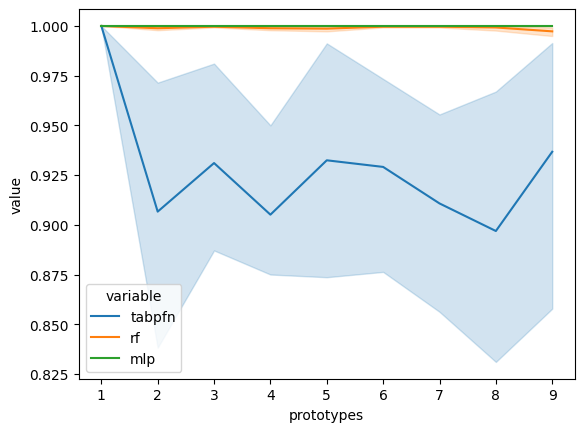

In [99]:
import seaborn as sns
a = sns.lineplot(data=df_subset_5_lenght_10.melt(id_vars="prototypes"), x="prototypes", y="value", hue="variable", )
a

In [166]:
def get_scores(length, subset_size, n_prototypes, models):
    X, y = make_binary_data(length=length, subset_size=subset_size, n_prototypes=n_prototypes)
    result = {'prototypes': n_prototypes}
    for model_name, model in models.items():
        result[model_name] = np.mean(cross_validate(model, X, y)['test_score'])
    return result

In [117]:
from joblib import Parallel, delayed

<AxesSubplot:xlabel='prototypes', ylabel='score'>

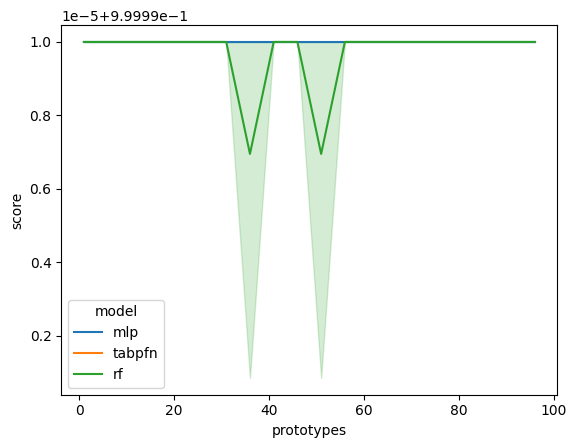

Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

Using a Transformer with 25.83 M parameters
Using cpu device


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

In [177]:
rf_scores = []
tabpfn_scores = []
mlp_scores = []
import torch
torch.set_num_threads(1)
prototypes = np.arange(1, 200, 5)
models = {
    'mlp': MLPClassifier(max_iter=1000),
    'tabpfn': tabpfn,
    'rf': RandomForestClassifier()
}
res_subset_7 = Parallel(n_jobs=-1)(delayed(get_scores)(length=10, subset_size=7, n_prototypes=n_prototypes, models=models) for i in range(5) for n_prototypes in prototypes)
res_subset_7 = pd.DataFrame.from_dict(res)
sns.lineplot(data=res_subset_7.melt(id_vars="prototypes", var_name="model", value_name="score"), x="prototypes", y="score", hue="model")

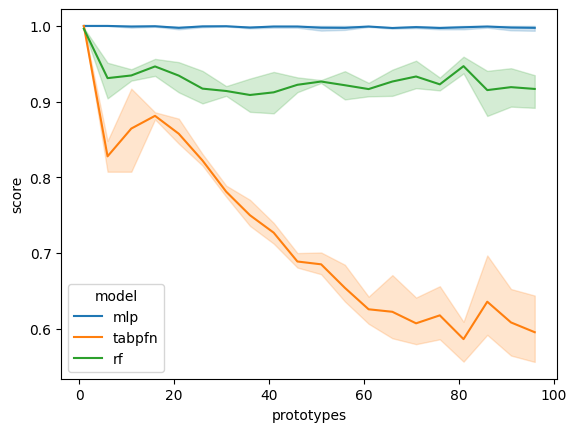

<AxesSubplot:xlabel='prototypes', ylabel='score'>

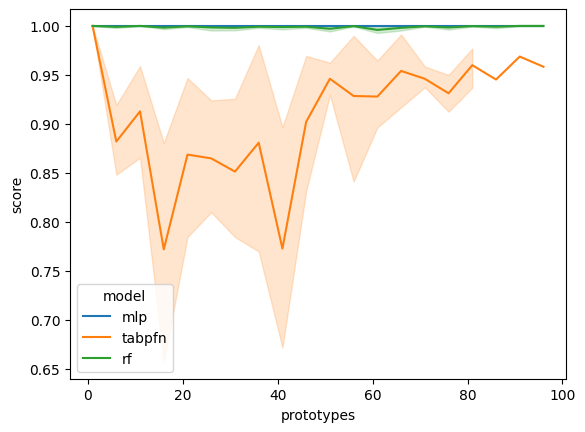

In [163]:
import torch
torch.set_num_threads(1)
prototypes = np.arange(1, 100, 5)
models = {
    'mlp': MLPClassifier(max_iter=1000),
    'tabpfn': tabpfn,
    'rf': RandomForestClassifier()
}
res = Parallel(n_jobs=-1)(delayed(get_scores)(length=10, subset_size=5, n_prototypes=n_prototypes, models=models) for i in range(5) for n_prototypes in prototypes)
res_subset_5 = pd.DataFrame.from_dict(res)
sns.lineplot(data=res_subset_5.melt(id_vars="prototypes", var_name="model", value_name="score"), x="prototypes", y="score", hue="model")

<AxesSubplot:xlabel='prototypes', ylabel='score'>

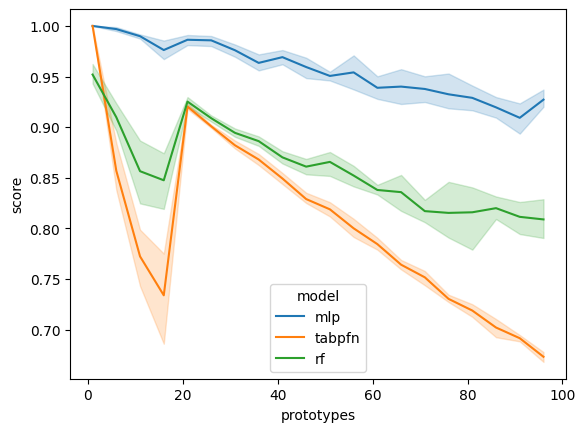

In [164]:
import torch
torch.set_num_threads(1)
prototypes = np.arange(1, 100, 5)
models = {
    'mlp': MLPClassifier(max_iter=1000),
    'tabpfn': tabpfn,
    'rf': RandomForestClassifier()
}
res = Parallel(n_jobs=-1)(delayed(get_scores)(length=10, subset_size=8, n_prototypes=n_prototypes, models=models) for i in range(5) for n_prototypes in prototypes)
res_subset_5 = pd.DataFrame.from_dict(res)
sns.lineplot(data=res_subset_5.melt(id_vars="prototypes", var_name="model", value_name="score"), x="prototypes", y="score", hue="model")

<AxesSubplot:xlabel='prototypes', ylabel='score'>

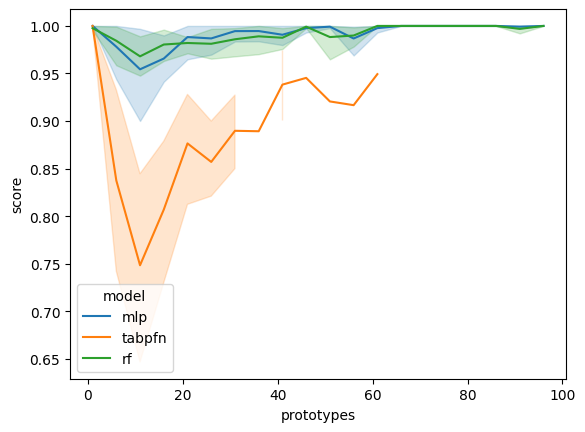

In [167]:

prototypes = np.arange(1, 100, 5)
models = {
    'mlp': MLPClassifier(max_iter=1000),
    'tabpfn': tabpfn,
    'rf': RandomForestClassifier()
}
res = Parallel(n_jobs=-1)(delayed(get_scores)(length=8, subset_size=4, n_prototypes=n_prototypes, models=models) for i in range(5) for n_prototypes in prototypes)
res_subset_5 = pd.DataFrame.from_dict(res)
sns.lineplot(data=res_subset_5.melt(id_vars="prototypes", var_name="model", value_name="score"), x="prototypes", y="score", hue="model")

In [175]:
prototypes = np.arange(1, 100, 5)

pd.DataFrame([pd.Series(make_binary_data(length=10, subset_size=8, n_prototypes=n_prototypes)[1]).value_counts()  for i in range(5) for n_prototypes in prototypes])

,True,False
0,652,372
1,832,192
2,676,348
3,572,452
4,544,480
...,...,...
95,760,264
96,744,280
97,712,312
98,720,304


/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpfn/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/anaconda/envs/tabpf

<AxesSubplot:xlabel='prototypes', ylabel='score'>

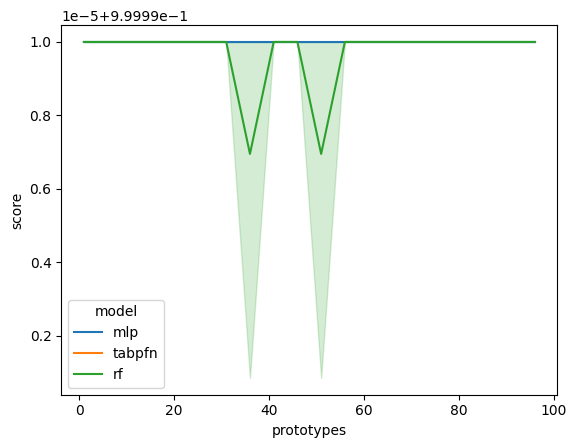

In [171]:
prototypes = np.arange(1, 100, 5)
models = {
    'mlp': MLPClassifier(max_iter=1000),
    'tabpfn': tabpfn,
    'rf': RandomForestClassifier()
}
res = Parallel(n_jobs=-1)(delayed(get_scores)(length=16, subset_size=8, n_prototypes=n_prototypes, models=models) for i in range(5) for n_prototypes in prototypes)
res_subset_5 = pd.DataFrame.from_dict(res)
sns.lineplot(data=res_subset_5.melt(id_vars="prototypes", var_name="model", value_name="score"), x="prototypes", y="score", hue="model")

In [172]:
res_subset_5

,prototypes,mlp,tabpfn,rf
0,1,1.0,NaN,1.0
1,6,1.0,NaN,1.0
2,11,1.0,NaN,1.0
3,16,1.0,NaN,1.0
4,21,1.0,NaN,1.0
...,...,...,...,...
95,76,1.0,NaN,1.0
96,81,1.0,NaN,1.0
97,86,1.0,NaN,1.0
98,91,1.0,NaN,1.0


In [198]:
inputs[:, selected_bits]

array([[0, 0],
       [1, 0],
       [0, 1],
       [1, 1],
       [0, 0],
       [1, 0],
       [0, 1],
       [1, 1],
       [0, 0],
       [1, 0],
       [0, 1],
       [1, 1],
       [0, 0],
       [1, 0],
       [0, 1],
       [1, 1],
       [0, 0],
       [1, 0],
       [0, 1],
       [1, 1],
       [0, 0],
       [1, 0],
       [0, 1],
       [1, 1],
       [0, 0],
       [1, 0],
       [0, 1],
       [1, 1],
       [0, 0],
       [1, 0],
       [0, 1],
       [1, 1]])

In [205]:
inputs[:, selected_bits]

array([[0, 0],
       [1, 0],
       [0, 0],
       [1, 0],
       [0, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [0, 0],
       [1, 0],
       [0, 0],
       [1, 0],
       [0, 1],
       [1, 1],
       [0, 1],
       [1, 1]])

In [214]:
(np.random.choice([-1, 1], size=clause_rank) * (2 * inputs[:, selected_bits] - 1) + 1) / 2

array([[1., 1.],
       [0., 1.],
       [1., 1.],
       [0., 1.],
       [1., 0.],
       [0., 0.],
       [1., 0.],
       [0., 0.],
       [1., 1.],
       [0., 1.],
       [1., 1.],
       [0., 1.],
       [1., 0.],
       [0., 0.],
       [1., 0.],
       [0., 0.]])

In [216]:
np.array(np.meshgrid(*[[-1, 1]]*n)).T.reshape(-1, n)

array([[-1, -1, -1, -1],
       [-1,  1, -1, -1],
       [ 1, -1, -1, -1],
       [ 1,  1, -1, -1],
       [-1, -1,  1, -1],
       [-1,  1,  1, -1],
       [ 1, -1,  1, -1],
       [ 1,  1,  1, -1],
       [-1, -1, -1,  1],
       [-1,  1, -1,  1],
       [ 1, -1, -1,  1],
       [ 1,  1, -1,  1],
       [-1, -1,  1,  1],
       [-1,  1,  1,  1],
       [ 1, -1,  1,  1],
       [ 1,  1,  1,  1]])

In [218]:
outputs

array([False, False, False,  True, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True])

In [223]:

def function_of_rank(rank=2, length=4):
    inputs = np.array(np.meshgrid(*[[-1, 1]]*length)).T.reshape(-1, length)
    outputs = np.zeros(2**length, dtype=bool)


    while 3 * outputs.sum() < len(inputs):
        selected_bits = np.random.choice(length, size=rank, replace=False)
        signs = np.random.choice([-1, 1], size=rank)
        outputs = outputs + ((signs * inputs[:, selected_bits]) == 1).all(axis=1)
    return (inputs + 1) / 2, outputs

In [225]:
function_of_rank(rank=2, length=8)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 1., ..., 1., 1., 1.],
        [1., 0., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]),
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False,  True,
        False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False,  True, False,  True, False,  True, False,
         True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False

In [240]:
def get_scores_rank(length, rank, models):
    X, y = function_of_rank(length=length, rank=rank)
    result = {'rank': rank}
    for model_name, model in models.items():
        result[model_name] = np.mean(cross_validate(model, X, y, cv=StratifiedKFold(shuffle=True))['test_score'])
    return result

<AxesSubplot:xlabel='rank', ylabel='score'>

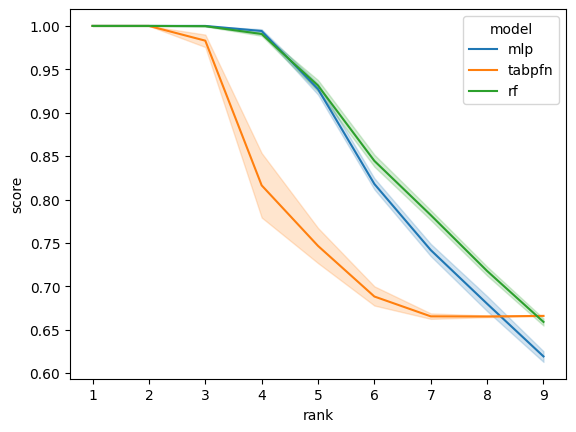

Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with

In [243]:
prototypes = np.arange(1, 100, 5)
models = {
    'mlp': MLPClassifier(max_iter=4000),
    'tabpfn': tabpfn,
    'rf': RandomForestClassifier()
}
res = Parallel(n_jobs=-1)(delayed(get_scores_rank)(length=10, rank=rank, models=models) for i in range(20) for rank in range(1, 10))
rank2 = pd.DataFrame.from_dict(res)


<AxesSubplot:xlabel='rank', ylabel='score'>

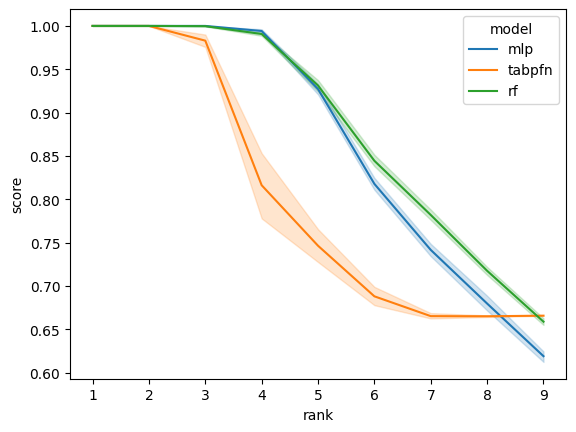

Bad pipe message: %s [b'A2&\xb8U\xef)\xab\xc9\xa5\xf0\xe7b\x88\xa6\xd9 / Z\xca\xc1\x9e\xac\xf4|\xc7\xfb\xd8;\x15\x9f\xd0\xbaQ\xd6=\xe3\x7fv]\x9a\xf3\xc6\xa4\xd0\x86T\x16q\xe2\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07']
Bad pipe message: %s [b'\x08\t\x08\n\x08\x0b\x08']
Bad pipe message: %s [b'\x05\x08\x06']
Bad pipe message: %s [b'\x05\x01\x06', b'']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 5\xd5\xa2\x9e\x9f\xfe\xfc\x1fn\xf7\xd1/\x83\xb3\xc6l+bh\xc4Z#']
Bad pipe message: %s [b'>\n\xb8v7\xc9\x95\xa4\x1av\xb7u\xa3\xb3\xf3[\xb4']
Bad pipe message: %s [b"\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc

In [244]:
sns.lineplot(data=rank2.melt(id_vars="rank", var_name="model", value_name="score"), x="rank", y="score", hue="model")